#  Estimating Home Value: A Zillow Data Science Project

## Project goal

- Find the key drivers of property value for single family properties.
- Construct an ML Regression model that predicts propery tax assessed values.
- Make recommendations on what works or doesn't work in predicting these homes' values

In [1]:
import warnings
import pandas as pd

import acquire as a
import prepare as p 
import explore as e 


from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE

# Ignore all warnings
warnings.simplefilter("ignore")

## Acquire

- Acquiring specific columns that i need for the project from the zillow dataset using sql.
- Read the sql query into a dataframe.
- It contained 52_441 rows and 22 columns before cleaning

## Prepare data

* Create new columns by transforming and utilizing existing data features.
    - Changed column names to something readable.
    - Dropped all 2414 rows with null values in the df.
    - Binned different values in specific columns.
    - Created 2 different columns to represent county and state.
    - One-hot encode categorical culomns with get dummies.

## Data Dictionary

| Feature                | Definition | Data Type |
|:-----------------------|:-----------|:----------|
| finishedsquarefeet12   | Finished square footage of the property | float64 |
| squarefeet             | Square footage of the property | float64 |
| latitude               | Latitude coordinate of the property | float64 |
| regionidzip            | Region ID of the property's ZIP code | float64 |
| longitude              | Longitude coordinate of the property | float64 |
| lotsizesquarefeet      | Square footage of the property's lot | float64 |
| logerror               | Logarithm of the error in the property's Zillow estimate | float64 |
| year_built             | Year the property was built | float64 |
| id                     | Identifier for the property | int64 |
| rawcensustractandblock | Raw census tract and block identifier | float64 |
| regionidcity           | Region ID of the property's city | float64 |
| bathrooms              | Number of bathrooms in the property | float64 |
| bedrooms               | Number of bedrooms in the property | float64 |
| fips                   | Federal Information Processing Standards (FIPS) code for the property's location | float64 |
| tax_value              | Property tax value | float64 |
| bedrooms_bin           | Categorical variable representing a bin for the number of bedrooms | category |
| bathrooms_bin          | Categorical variable representing a bin for the number of bathrooms | category |
| squarefeet_bin         | Categorical variable representing a bin for the square footage of the property | category |
| decades                | Categorical variable representing the decade in which the property was built | category |

In [2]:
# acquiring, cleaning, and adding features to data
# Call the clean_and_convert() function to obtain a cleaned and converted DataFrame.
df = a.clean_and_converts()

# Split the DataFrame 'df' into training, validation, and test sets using the train_val_test function.
train, val, test = a.train_val_test(df)

### A concise summary of the data

In [3]:
#using.info() to check all the data types and null values

train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35018 entries, 12650 to 16552
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   finishedsquarefeet12    35018 non-null  float64 
 1   squarefeet              35018 non-null  float64 
 2   latitude                35018 non-null  float64 
 3   regionidzip             35018 non-null  float64 
 4   longitude               35018 non-null  float64 
 5   lotsizesquarefeet       35018 non-null  float64 
 6   logerror                35018 non-null  float64 
 7   year_built              35018 non-null  float64 
 8   id                      35018 non-null  int64   
 9   id.1                    35018 non-null  int64   
 10  rawcensustractandblock  35018 non-null  float64 
 11  regionidcity            35018 non-null  float64 
 12  parcelid                35018 non-null  int64   
 13  parcelid.1              35018 non-null  int64   
 14  bathrooms              

### Explore

# Does squarefeet affect tax value?

#### Creating a scatterplot to visualize the relationship between square feet and tax value.

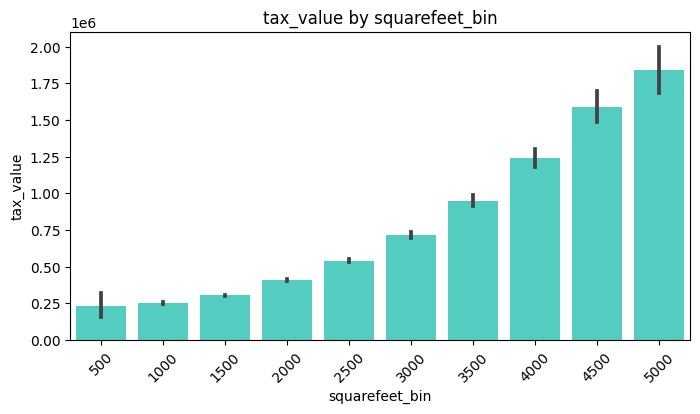

In [4]:
e.different_plots(train, 'squarefeet_bin', 'tax_value', 'bar')

#### Takeaway

From the barplot we can deduce that there is a relationship between squarefeet and tax value because as square feet increases, the tax_value exponentially increases.

### Pearson's Correlation Coefficient (r)

Null hypothesis: There is no significant linear correlation between squarefeet and tax_value in the population. 

Alternative hypothesis: There is a significant linear correlation between squarefeet and tax_value in the population. 

I will now use a Pearson's Correlation Coefficient (r) to investigate whether squarefeet affects tax_value

I will use a confidence interval of 95%  
The resulting alpha is .05

In [5]:
e.pearson_correlation(train.squarefeet, train.tax_value)

('We reject the null hypothesis. There appears to be a relationship.',
 'r = 0.523709059802853.',
 'p = 0.0.')

#### Takeaway

- The value of r is approximately 0.524, which indicates the strength and direction of the linear relationship.  
- The p-value is very close to zero (0.0), which means it's highly statistically significant.

# Does FIPS affect tax value?

#### Creating a barplot to visualize the relationship between the FIPS region and tax value.

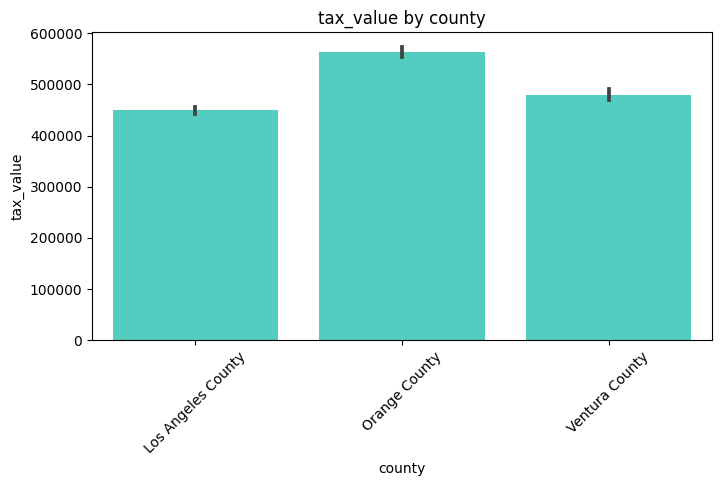

In [6]:
e.different_plots(train, 'county', 'tax_value', 'bar')

#### Takeaway

- It appears that there is variation in tax_value among the different FIPS regions. FIPS 6059, in particular, stands out with the highest median tax_value, while FIPS 6037 has the lowest median tax_value. This suggests that the FIPS region may be a key driver of property value, as there is a significant difference in tax_value among these regions.

### ANOVA test

Null Hypothesis: There is no significant difference in tax values among the different FIPS regions.  

Alternative Hypothesis: There is a significant difference in tax values among at least two of the FIPS regions.

- This test investigates whether there are significant differences in tax_value among different FIPS regions.

In [7]:
e.perform_anova(df, alpha=0.05)

('We reject the null hypothesis. There is a significant difference among FIPS regions.',
 2.1641653140251805e-90)

#### Takeaway

- The p-value provides strong evidence to conclude that at least one of the FIPS regions has a significantly different tax value from the others.

# Is there a correlation between tax value and number of bedrooms?

#### Creating a barplot to visualize the correlation between tax value and the number of bedrooms.

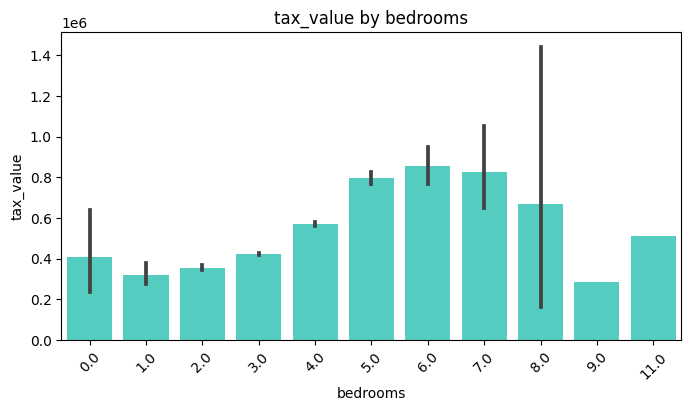

In [8]:
e.different_plots(train, 'bedrooms', 'tax_value', 'bar')

#### Takeaway

- The chart shows that on average 5 to 7 bedroom houses have the highest tax value.

### Pearson's Correlation Coefficient (r)

Null Hypothesis: There is no correlation between the number of bedrooms and tax_value for single-family properties.   

Alternative Hypothesis: There is a correlation between the number of bedrooms and tax_value for single-family properties.

I will now use a Pearson's Correlation Coefficient (r) to investigate whether there a correlation between tax value and number of bedrooms.

I will use a confidence interval of 95%  
The resulting alpha is .05

In [9]:
e.pearson_correlation_test(df.bedrooms, df.tax_value)

('We reject the null hypothesis. There is a correlation between tax value and number of bedrooms.',
 0.22246526953130105,
 0.0)

#### Takeaway

- The analysis conducted indicates a statistically significant, positive correlation between the number of bedrooms and property tax values. This suggests that, on average, properties with more bedrooms tend to have higher tax values. However, it's important to note that correlation does not imply causation, and other factors may also influence tax values.
- Further investigation and consideration of additional variables are recommended for a more comprehensive understanding of property tax determinants.

# Does the year the property was built affect the value?

### Scatterplot

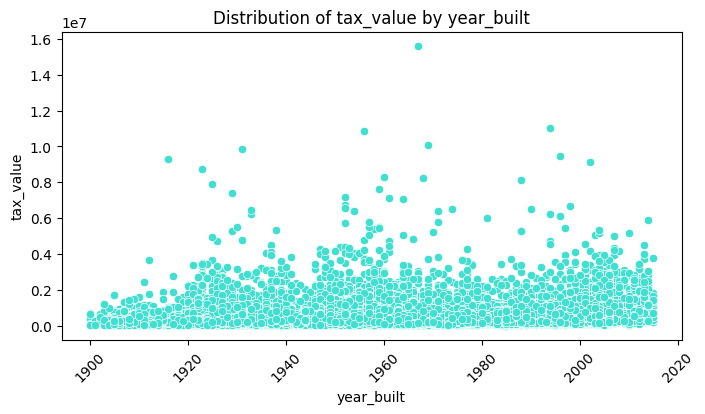

In [10]:
e.different_plots(train, 'year_built', 'tax_value', 'scatter')

#### Takeaway from scatter plot

- From the scatterplot we can deduce that tax_value on average increses moderately as the years go by.

# Is there a relationship between tax value and number of bathrooms?

### Barplot

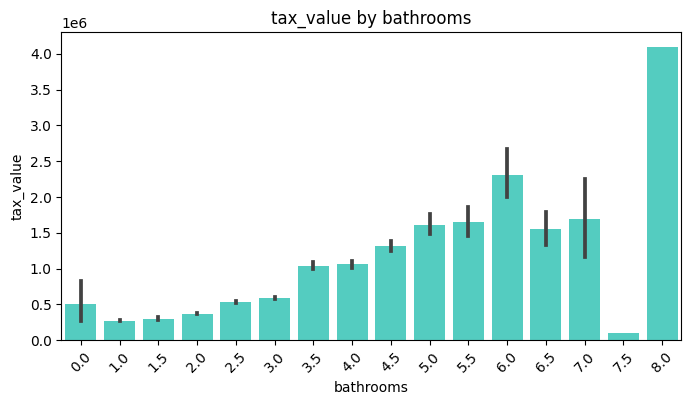

In [11]:
e.different_plots(train, 'bathrooms', 'tax_value', 'bar')

### Takeaway from barplot.

- The barplot indicates that the more bathrooms a single family residence has the higher the tax_value with the exception of 6.5 to 7.5 bathroom houses.

## Exploratory summary

- Square Footage Impact: There is a moderate positive relationship between square footage and tax value, indicating larger properties tend to have higher tax assessments.

- FIPS Regions Matter: Geographic location, represented by FIPS regions, significantly influences property tax values, with notable differences among regions.

- Bedrooms and Tax Values: The number of bedrooms is positively correlated with tax values, suggesting that homes with more bedrooms command higher tax assessments.

- Year Built Trend: Newer homes tend to have higher tax values, indicating a trend of increasing tax assessments over time.

- Bathrooms and Tax Values: The number of bathrooms positively influences tax values, with properties featuring more bathrooms generally having higher tax assessments.

# Modeling

#### Features for modeling

1) finishedsquarefeet12 
2) squarefeet 
3) latitude
4) regionidzip
5) longitude 
6) lotsizesquarefeet
7) logerror
8) year_built
9) id
10) rawcensustractandblock
11) regionidcity
12) parcelid
13) bathrooms
14) bedrooms
15) fips
16) tax_value
17) bedrooms_bin
18) bathrooms_bin
19) squarefeet_bin
20) decades
21) state
22) county

#### Goal:

- Establish a baseline to judge model efficiency against

- Create multiple models

- Determine the best 3 models to run on my validate dataset

- Assess models created using four distinct model types and a range of hyperparameter settings.

- Models will undergo evaluation on both the training and validation datasets. The top-performing model will subsequently be assessed using the test dataset.

In [12]:
#one-hot encode train, val and test
train, val, test = p.convert_and_rename_dummies(train, val, test)

In [13]:
# Scale the training, validation, and test datasets using the specified columns.
train, val, test = p.scaled_data(train, val, test, scaler_type='minmax')

In [14]:
# Split the 'train' dataset into feature matrix (X_train) and target vector (y_train).
X_train, y_train = p.xy_split(train)

# Split the 'val' dataset into feature matrix (X_val) and target vector (y_val).
X_val, y_val = p.xy_split(val)

# Split the 'val' dataset into feature matrix (X_val) and target vector (y_val).
X_test, y_test = p.xy_split(test)

In [15]:
# Calculate the mean and median of the target vector 'y_train'.
y_train.mean(), y_train.median()

(482910.5436632589, 364341.5)

### Baseline

In [16]:
# Create a DataFrame 'baselines' with three columns: 'y_actual,' 'y_mean,' and 'y_median.'
baselines= e.create_baselines(y_train)

In [17]:
# Evaluate the model's performance by comparing its predictions against the mean ('y_mean') of the target values.
p.eval_model(baselines.y_actual, baselines.y_mean)

523729.63

In [18]:
# Perform polynomial feature expansion on the training, validation, and test datasets
X_train_s, X_val_s, X_test_s, poly = e.polynomial_feature_expansion(X_train, X_val, X_test)

### TweedieRegressor

In [19]:
# Create an instance of the Tweedie Regressor model.
tweedie = TweedieRegressor(power=1, alpha=0.01, link='auto', max_iter=170)

# Train the Tweedie Regressor model on the training data with polynomial features (X_train_s, y_train).
# Evaluate its performance using the validation data with polynomial features (X_val_s, y_val).
e.train_model(tweedie, X_train_s, y_train, X_val_s, y_val)

The train RMSE is 391969.53.
The validate RMSE is 383782.4.


TweedieRegressor(alpha=0.01, max_iter=170, power=1)

#### Takeaway

- The TweedieRegressor model outperforms the baseline model, showcasing its potential for predicting property tax assessed values.

### RandomForestRegressor

In [20]:
# Create an instance of the RandomForestRegressor model.
rf = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=4)

# Train the RandomForestRegressor model on the training data (X_train_s, y_train).
# Evaluate its performance using the validation data (X_val_s, y_val).
e.train_model(rf, X_train_s, y_train, X_val_s, y_val)

The train RMSE is 265693.49.
The validate RMSE is 361541.69.


RandomForestRegressor(max_depth=10, min_samples_split=4)

#### Takeaway

- The model demonstrates a substantially lower training RMSE compared to the baseline, indicating its capability to capture patterns within the training data effectively.
- However, the validation RMSE is still relatively high, suggesting a potential overfitting issue or the need for further hyperparameter tuning.

### XGBRegressor

In [24]:
# Create an instance of the XGBoost Regressor model.
xgbr = XGBRegressor(colsample_bytree =  0.8, learning_rate = 0.1, max_depth = 5, n_estimators = 200, subsample =  1.0)

# Train the XGBoost Regressor model on the training data (X_train_s, y_train).
# Evaluate its performance using the validation data (X_val_s, y_val).
e.test_model(xgbr, X_train_s, y_train, X_val_s, y_val)

The train RMSE is 245941.25.
The test RMSE is 355484.24.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

| Model                  | Train RMSE | Validate RMSE |
|:-----------------------|------------|---------------|
| Tweedie Regressor      | 391,969.53 | 383,782.40    |
| RandomForest Regressor | 265,693.49 | 361,541.69    |
| XGBoost Regressor      | 245,941.25 | 355,484.24    |


### Model Comparison

| Model                  | Train RMSE | Validate RMSE |
|:-----------------------|------------|---------------|
| Tweedie Regressor      | 391,969.53 | 383,782.40    |
| RandomForest Regressor | 265,693.49 | 361,541.69    |
| XGBoost Regressor      | 245,941.25 | 355,484.24    |

### Model Summary

- The Tweedie Regressor has the highest RMSE on both the train and validate datasets, indicating that it performs the worst in terms of predictive accuracy.
- The RandomForest Regressor has a lower RMSE on the train dataset compared to the Tweedie Regressor, but it has a higher RMSE on the validate dataset, suggesting that it might be overfitting the training data.
- The XGBoost Regressor outperforms both the Tweedie and RandomForest models with the lowest RMSE on the validate dataset. It also has a lower RMSE on the train dataset compared to the Tweedie and RandomForest models, indicating that it generalizes well to unseen data.
- Based on these RMSE values, the XGBoost Regressor appears to be the best-performing model among the three for this particular task, as it has the lowest validation error. However, it's essential to consider other factors like model interpretability, computational efficiency, and specific business requirements when choosing the best model for a real-world application.

### XGBRegressor

In [21]:
# Create an instance of the XGBoost Regressor model.
xgbr = XGBRegressor(colsample_bytree =  0.8, learning_rate = 0.1, max_depth = 5, n_estimators = 200, subsample =  1.0)

# Train the XGBoost Regressor model on the training data (X_train_s, y_train).
# Evaluate its performance using the validation data (X_val_s, y_val).
e.train_model(xgbr, X_train_s, y_train, X_val_s, y_val)

The train RMSE is 245941.25.
The validate RMSE is 355484.24.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

#### Takeaway

- The training RMSE demonstrates that the model is learning well from the training data, as it is considerably lower than the baseline.
- However, the relatively high validation RMSE suggests the possibility of overfitting or the need for additional hyperparameter optimization to enhance the model's generalization to new data.

### Model Comparison

#### Tweedie Regressor
- Train RMSE: 392,120.80
- Validate RMSE: 383,961.47
#### Random Forest Regressor
- Train RMSE: 264,858.39
- Validate RMSE: 364,851.95
#### XGBoost Regressor
- Train RMSE: 275,258.37
- Validate RMSE: 357,228.54

While XGBoost is a little overfit, it is my best performing model so I have decided to proceed with it for further testing.

# Test

### XGBRegressor

In [22]:
# Create an instance of the XGBoost Regressor model.
xgbr = XGBRegressor(colsample_bytree =  0.8, learning_rate = 0.1, max_depth = 5, n_estimators = 200, subsample =  1.0)

# Train the XGBoost Regressor model on the training data (X_train_s, y_train).
# Evaluate its performance using the validation data (X_val_s, y_val).
e.test_model(xgbr, X_train_s, y_train, X_test_s, y_test)

The train RMSE is 245941.25.
The test RMSE is 356434.56.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

- The XGBoost Regressor demonstrates strong performance with a low training RMSE of 245,941.25, indicating its ability to model the training data effectively.

- However, it exhibits a higher test RMSE of 356,434.56, suggesting that it may need further tuning to enhance its generalization to unseen data.

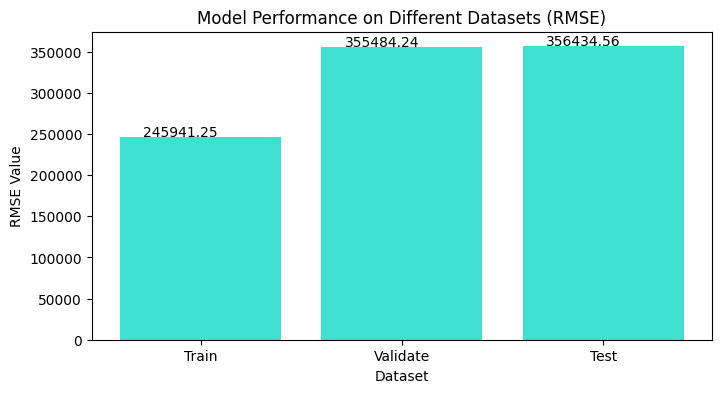

In [23]:
# Plot the RMSE values for different datasets using a bar chart
e.plot_rmse_bar_chart()

## Conclusion

**Predicting Property Tax Assessed Values for Single Family Properties**

- In this Zillow project, my objective was to construct a robust machine learning regression model capable of predicting property tax assessed values ('taxvaluedollarcnt') for single-family properties. Throughout this project, I've explored the data, performed statistical tests, created visualizations, and built several regression models. Here are the key takeaways:


1. **Data Exploration and Understanding:**
   - I began by thoroughly exploring the dataset, understanding its structure, and identifying key features related to property tax values. This initial step helped me gain insights into the data and its potential drivers.


2. **Statistical Tests:**
   - I conducted several statistical tests to investigate relationships between various features and the target variable, taxvaluedollarcnt. These tests included:
     - Pearson's Correlation Coefficient to examine the correlation between numeric features and tax value.
     - Chi-Square Test of Independence to assess the relationship between categorical variables like the presence of tech support and churn.
     - ANOVA to analyze variations in tax value across different FIPS regions.

3. **Visualizations:**
   - I utilized a variety of visualizations to better understand the data and relationships between features:
     - Scatter plots to visualize the correlation between numeric features and tax value.
     - Bar plots to compare tax values across categories, such as the number of bathrooms and FIPS regions.

4. **Regression Models:**
   - I trained and evaluated three regression models: Tweedie Regressor, Random Forest Regressor, and XGBoost Regressor.
   - While the models showed promise on the training data with reduced RMSE values compared to the baseline, they struggled to generalize effectively to the validation data. Further model refinement, hyperparameter tuning, and feature engineering are recommended.

5. **Key Findings:**
   - Despite some limitations in model performance, I made several noteworthy findings:
     - Property tax values are influenced by various factors, including property size (square footage) and location (FIPS region).
     - The number of bedrooms and bathrooms, as well as the year the property was built, have some impact on tax values.
     - Differences in tax values among FIPS regions indicate the importance of considering location as a key factor in property value estimation.

6. **Recommendations:**
   - To build a more accurate predictive model, I recommend further feature engineering to capture additional insights.
   - Hyperparameter tuning, model selection, and addressing potential overfitting should be explored to enhance model performance.
   - A deeper analysis of location-based features and external data sources could provide valuable context for property value estimation.

#### In conclusion, this project has laid a strong foundation for predicting property tax assessed values, and while our models show promise, there is room for improvement. 
- The insights gained from statistical tests, visualizations, and initial modeling efforts will serve as a valuable starting point for the Zillow data science team to refine their property value prediction models and better understand the drivers of property values for single-family properties.